## Housing prices - Statistical methods for machine learning's project


### Aggiudicato Irene (960261) - master in Data science and economics 

The aim of this project is apply Ridge Regression on a dataset describing California's houses in order to check the improvement of stability and the outcome of this algorithm at the variation of the parameter $\alpha $. 
In order to measure the error of the algorithm we are going to perform K-fold cross validation which will allows us to split the dataset into 5 different folds and check the mean square error taken one fold at time as test set; averaging the errors that we will have, could permit us to have an overall score of the error itself. 
In the end we will perform principal component analysis which allows us to project our data into a lower dimensional space. Once again we will perform cross validation to check how this result could be comparable to the ones found with the regression algorithm. 

In [1]:
#importing the libraries that we will need to use for computing the analysis
import numpy as np
from numpy import linalg as LA
import pandas as pd
from pandas import read_csv
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### Preprocessing and preliminary observations

In [2]:
#importing the dataset of the analysis
data = read_csv ('cal-housing.csv')
data.head()     #showing the dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
print(data)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  media

As we can see our dataset is composed by 10 different attributes on 20640 different observations. The variable used as target for the regression is the median_house_value, all the others will be used as the explanatory ones. It is really important to have not null values in the dataset as this would cause problems during the analysis, for this reason we are going to check, and then drop, all the null values present in the dataset. 

In [4]:
#checking which is the variable that contains null values
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
#droping the null values
housing = data.dropna()

In [6]:
#double-check for seeing if effectively we have dropped the null values
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

What we are going to do next is to plot our datapoints and then the target value that we will use in order to have a look on the distribution of data and making the first inferences on them. 
Here we can see that the more expensive houses are those located near the ocean and in particular in two zones, those referring to San Francisco and Los Angeles.  

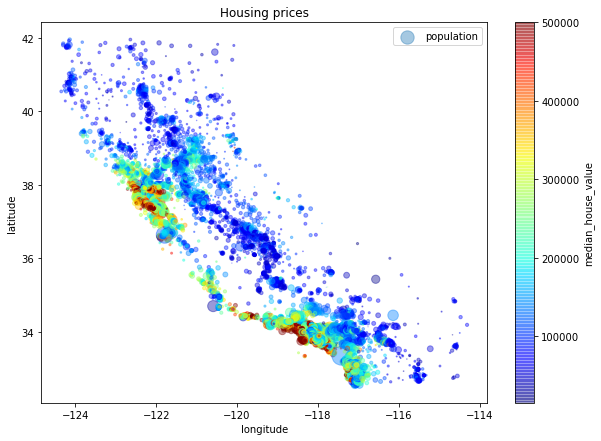

In [7]:
#plotting the values of the labels in order to see where are located the houses that are more expensive

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.title('Housing prices')
plt.legend()


For what concerns the distribution of the target variable: we can say that it is slightly shrink to the left, having a mode between 100000 and 200000. What it is tangible is that there are a lot of observations which take the value of 500000. These could be considered as outliers and since they could cause a great imbalance in the analysis, we have decided to exclude them from the analysis. 

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


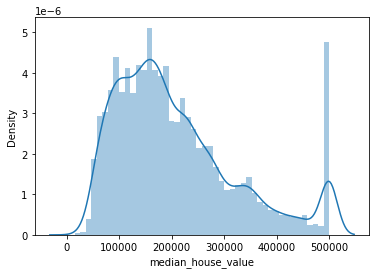

<Figure size 432x288 with 0 Axes>

In [8]:
#see the distribution of the variable median_house_value 
sns.distplot(housing['median_house_value']);
fig = plt.figure()

In [9]:
#leaving aside those variables for which we have a median_house_value greater than 500000
housing = data[data['median_house_value'] < 500000]  

In the dataset we have a categorical variable: ocean_proximity which tells us the closeness to the ocean of the houses. Of course we have to transform it into a dummy variable.

In [10]:
#taking just the categorical variable for making further modification
ocean = housing.pop('ocean_proximity')

In [11]:
ocean.head()

0    NEAR BAY
1    NEAR BAY
2    NEAR BAY
3    NEAR BAY
4    NEAR BAY
Name: ocean_proximity, dtype: object

In [12]:
#creating dummy variables for the categorical variable
ocean = pd.get_dummies(ocean, columns=['ocean_proximity'])

In [13]:
#see how the variable has been transformed into dummies. It takes the value of 1 just on the corresponding level and 0 otherwise
ocean.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


Since among those 5 variables one of them will be of course collinear, we have decided to drop one of them. This is because, knowing the value of four dummies will enable us to know also the last one. So, we have decided to drop the 'INLAND' column. 

In [14]:
#dropping one of the level of the categorical variable since it will be collinear
ocean = ocean.drop(columns = 'INLAND')

At this point of the analysis we can standardize the data, making them having null mean and unitary variance. In this way variables will appear more "similar" between each other. This will be extremely useful in the analyses.

In [15]:
#standardizing the data, preprocessing phase
def standardization (data):  
    for j in data.columns:
        data[j] = (data[j] - data[j].mean())/data[j].std()  #getting the difference between the data and its mean and divide the result by its standard deviation
    return data 

In [16]:
#standardizing the data and see the result
standardization(housing)

<ipython-input-15-6fe60f6ae729>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[j] = (data[j] - data[j].mean())/data[j].std()  #getting the difference between the data and its mean and divide the result by its standard deviation


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.329981,1.036306,1.009828,-0.797452,-0.971821,-0.978405,-0.978615,2.959877,2.682961
1,-1.324995,1.027004,-0.589654,2.052199,1.340315,0.838784,1.660986,2.944724,1.713966
2,-1.334966,1.022353,1.889542,-0.528479,-0.827460,-0.826317,-0.845592,2.280010,1.648062
3,-1.339952,1.022353,1.889542,-0.616915,-0.720965,-0.772124,-0.736043,1.252188,1.536848
4,-1.339952,1.022353,1.889542,-0.455164,-0.614469,-0.766006,-0.631711,0.108105,1.546116
...,...,...,...,...,...,...,...,...,...
20635,-0.761617,1.780469,-0.269758,-0.437752,-0.392012,-0.521267,-0.446521,-1.347324,-1.173456
20636,-0.821445,1.785120,-0.829576,-0.881306,-0.922123,-0.948686,-1.009914,-0.712854,-1.183754
20637,-0.826431,1.757214,-0.909551,-0.167862,-0.129323,-0.379668,-0.177867,-1.258378,-1.027231
20638,-0.876287,1.757214,-0.829576,-0.348400,-0.309182,-0.612170,-0.396964,-1.151922,-1.105493


In [17]:
#creating a new dataset contains all the variable with the except of the target variable
X = housing.drop(columns = ['median_house_value'])

In [18]:
#taking just the target variable
y = housing['median_house_value']

### Multicollinearity

Ridge regression is particular useful when we are dealing with a dataset whose variables are particular collinear between each other. At this point of analysis we can check through an heatmap the collinearity between features.

In [19]:
#correlation between variables
corr = X.corr()

Text(0.5, 1.0, 'Correlations between attributes')

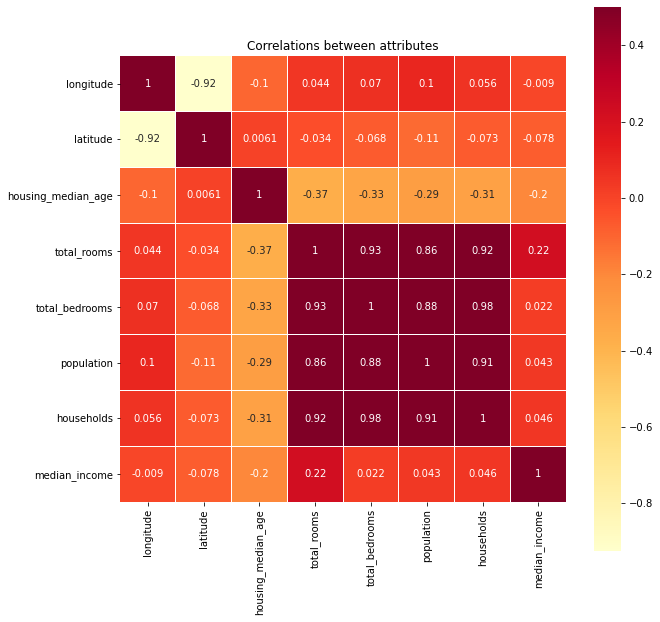

In [20]:
#creating the heatmap containing the degree of correlation of the variables
plt.figure(figsize = (10,10))
sns.heatmap (corr, vmax = .5, linewidths = 0.01,
            square = True, annot = True, cmap = 'YlOrRd', linecolor = "white")
plt.title('Correlations between attributes')

Since we can see that there is an highly correlation between total badrooms, total rooms, population and households, we can drop total bedrooms, household and population. 
There is a strongly correlation also between longitude and latitude, but this is because of the particular shape of California. 
Here a clarification should have been made: when we are talking about highly correlation, we mean a Pearson's coefficient higher than |0.5| as shown in the table below

In [21]:
#see the correlation between variables
corr [((corr > 0.5) | (corr < -0.5)) & (corr != 1.0)].dropna(axis = 'index', how = 'all')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
longitude,NaN,-0.924139,NaN,NaN,NaN,NaN,NaN,NaN
latitude,-0.924139,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_rooms,NaN,NaN,NaN,NaN,0.934233,0.859642,0.921177,NaN
total_bedrooms,NaN,NaN,NaN,0.934233,NaN,0.879269,0.979137,NaN
population,NaN,NaN,NaN,0.859642,0.879269,NaN,0.909090,NaN
households,NaN,NaN,NaN,0.921177,0.979137,0.909090,NaN,NaN


In [22]:
#dropping total bedrooms which is higly correlated with households
X = X.drop(columns = ['total_bedrooms'])

Text(0.5, 1.0, 'Correlations between attributes')

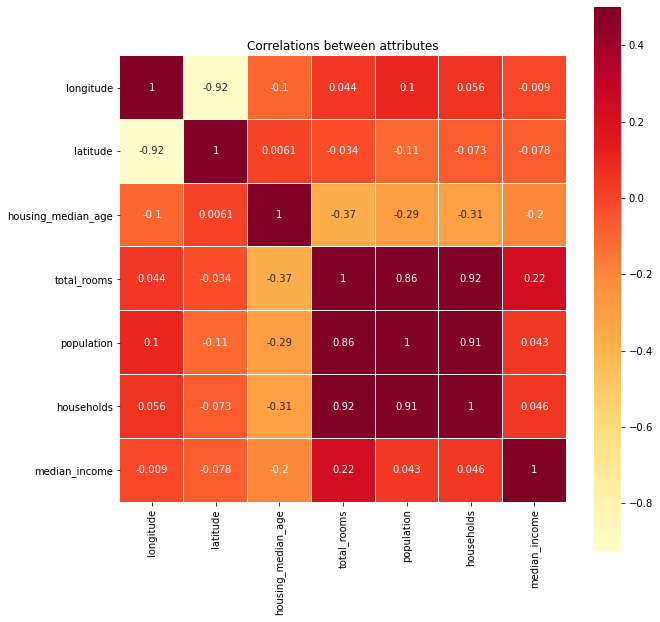

In [23]:
#heatmap without total bedrom that we have previously dropped
corr = X.corr()
plt.figure(figsize = (10,10))
sns.heatmap (corr, vmax = .5, linewidths = 0.01,
            square = True, annot = True, cmap = 'YlOrRd', linecolor = "white")
plt.title('Correlations between attributes')

In [24]:
#dropping household variable which is highly correlated with population
X = X.drop(columns = ['households'])

Text(0.5, 1.0, 'Correlations between attributes')

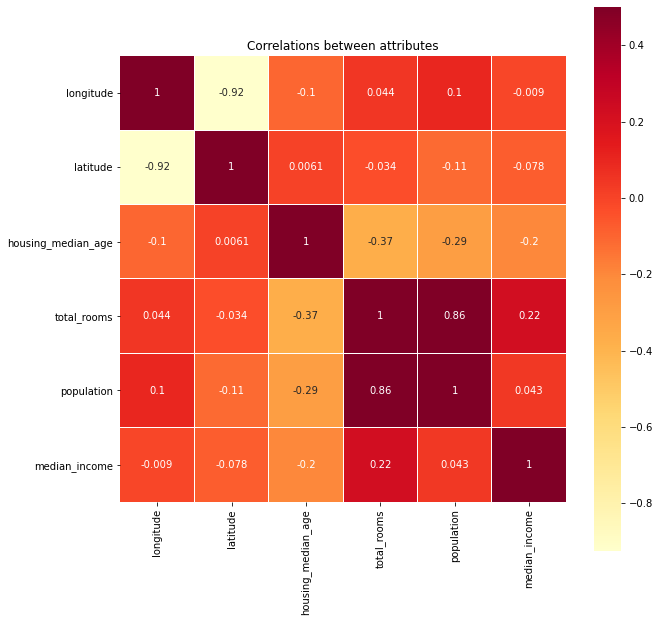

In [25]:
#new heatmap without the households variable that we have previously dropped
corr = X.corr()
plt.figure(figsize = (10,10))
sns.heatmap (corr, vmax = .5, linewidths = 0.01,
            square = True, annot = True, cmap = 'YlOrRd', linecolor = "white")
plt.title('Correlations between attributes')

In [26]:
#dropping the variable population which is strictly correlated with total rooms
X = X.drop(columns = ['population'])

Text(0.5, 1.0, 'Correlations between attributes')

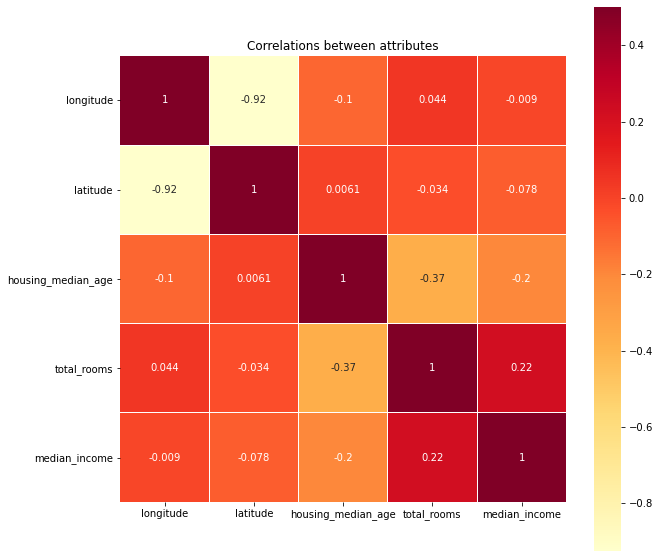

In [27]:
#creating the new heatmap, which now contains no variables strictly correlated between each others
corr = X.corr()
plt.figure(figsize = (10,10))
sns.heatmap (corr, vmax = .5, linewidths = 0.01,
            square = True, annot = True, cmap = 'YlOrRd', linecolor = "white")
plt.title('Correlations between attributes')

In [28]:
#adding the categorical variable that we had previously pop
X = pd.concat([X, ocean], axis=1)

In [29]:
#showing the clean dataset after pre-processing
X.head()

,longitude,latitude,housing_median_age,total_rooms,median_income,<1H OCEAN,ISLAND,NEAR BAY,NEAR OCEAN
0,-1.329981,1.036306,1.009828,-0.797452,2.959877,0,0,1,0
1,-1.324995,1.027004,-0.589654,2.052199,2.944724,0,0,1,0
2,-1.334966,1.022353,1.889542,-0.528479,2.280010,0,0,1,0
3,-1.339952,1.022353,1.889542,-0.616915,1.252188,0,0,1,0
4,-1.339952,1.022353,1.889542,-0.455164,0.108105,0,0,1,0


## Analysis

### Ridge regression algorithm 
At this point we can enter into the datail of our analysis. 
First of all we are going to defined ridge regression algorithm and apply it to a fixed level of $\alpha $, without split the dataset into training and test set. Then we are going to define the k-fold cross validation that we will use for estimating the mean square error. 

In [30]:
#see the shape of the matrix that we have 
X.shape

(19648, 9)

In [31]:
#see the shape of the vector for predicting the labels
y.shape

(19648,)

In [32]:
#ridge regression
def ridge_reg (X, y, alpha):
    matrix = X.T @ X
    alpha = alpha * np.ones(len(matrix)) 
    I = np.identity(len(matrix), dtype = float)
    A = (I @ alpha + matrix)
    B = X.T @ y
    W = np.linalg.solve(A,B)
    return W

In [33]:
#Checking the ridge regression with a prefixed value of alpha on the entire dataset - training set
ridge_reg(X, y, alpha = 0.2)

array([-0.80419007, -0.82946221,  0.12049316,  0.06969019,  0.57612396,
        0.06915094,  1.73621088,  0.04471891,  0.10039789])

In [34]:
#defining the square loss that we will use later on
def sqrloss (y1, y2): 
    return (y1 - y2)**2

In [35]:
#defyning the mean square error
def mse (y, yfit, loss_f): 
    return np.mean(loss_f(y, yfit))

### Cross validation analysis
What we have done till now is to implement the ridge regression algorithm from scratch and check it on the entire dataset. But what we have to do now is to evaluate the stability and accuracy of the algorithm itself through the evaluation of the mean square error. 
For doing this, instead of splitting the dataset into train and test set, we are going to partition the dataset into 5 different folds. The folds will be used one at time as test set on which will be evaluated the mean square error. Once done this, we will take the average of them for having a uniquely outcome. 

In [36]:
#dividing the data that we have into 5 different folds
X.index = y.index 
K = np.random.randint (0, 5, size = y.shape) 

In [37]:
#checking K which is an array containing numbers between 0 and 4
K

array([2, 0, 0, ..., 0, 4, 1])

In [38]:
#checking the length of the array that should be equal to the number of observations that we have
len(K)

19648

In [39]:
#initializing a list that will contain the mean square errors
errors = []

#taking the 5-folds one at time as test set and all the others as training set
for k in range (5): 
    X_train = X.loc[K != k, :]
    y_train = y.loc[K != k]
    X_test = X.loc[K == k, :]
    y_test = y.loc[K == k]
    beta = ridge_reg(X_train, y_train, alpha = 0.2)   #performing ridge regression on the training set
    err = mse(y_test, X_test @ beta, sqrloss) #mean square error on the test set 
    errors.append(err)

In [40]:
#look at the errors that we will get with a singular value of alpha
errors

[0.4268081967869966,
 0.44100557762362563,
 0.4171968236730205,
 0.42647298981245885,
 0.44799133003076197]

In [41]:
#compute the average of the errors
ave = np.average(errors)  

In [42]:
#showing the average of the error
ave

0.43189498358537276

Till now we have just check the mean square error for a prefixed value of alpha, what we want to do know is to check how this evaluation could change given different values of $ \alpha$. So we are going to do the same analysis as before but now we are going to let $ \alpha$ flactuates and taking 100 different values between 0 and 1

In [43]:
#defining cross validation error
def cv_err (X, K, y):
    pert = []  #initializing a list containing the different results given different values of alpha
    for alpha in np.linspace(0, 1, num=100): #defining 100 different values of alpha between 0 and 1
        errors = []
        for k in range (5): 
            X_train = X.loc[K != k, :]
            y_train = y.loc[K != k]
            X_test = X.loc[K == k, :]
            y_test = y.loc[K == k]
            beta = ridge_reg(X_train, y_train, alpha * X_train.shape[0])
            err = np.mean(np.square(y_test - X_test @ beta)) 
            errors.append(err)
        ave = np.average(errors)
        pert.append(ave)
    return pert 
        

In [44]:
#result of the previous definition 
err_data = cv_err (X, K, y)

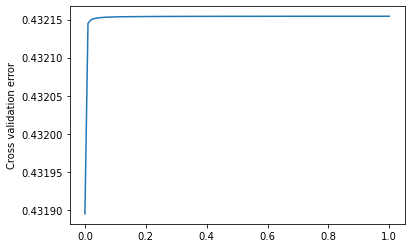

In [45]:
#plotting the results
plt.plot(np.linspace(0, 1, num = 100), err_data)
plt.ylabel('Cross validation error')
plt.show()

The results that we get is not so much different given different values of $ \alpha$, in fact also in the plot the error takes more or less the same value

### Principal component analysis

What we want to do now is to check the effects of a reduction in dimensionality of the ridge regression algorithm. For doing this we are going to perform principal component analysis which will allows us to project data into a low-dimensional space. For doing this we will use just the numerical values, leaving aside the categorical one. 

In [46]:
#taking the dataset containing just numerical variables 
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.329981,1.036306,1.009828,-0.797452,-0.971821,-0.978405,-0.978615,2.959877,2.682961
1,-1.324995,1.027004,-0.589654,2.052199,1.340315,0.838784,1.660986,2.944724,1.713966
2,-1.334966,1.022353,1.889542,-0.528479,-0.827460,-0.826317,-0.845592,2.280010,1.648062
3,-1.339952,1.022353,1.889542,-0.616915,-0.720965,-0.772124,-0.736043,1.252188,1.536848
4,-1.339952,1.022353,1.889542,-0.455164,-0.614469,-0.766006,-0.631711,0.108105,1.546116


In [47]:
#we don't know exactly why, since we have previously clean the data, but the dataset appeared still with some missing values. 
#we are dropping them
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        200
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [48]:
housing = housing.dropna()

In [49]:
#taking just the target value
f = housing['median_house_value']

In [50]:
#leaving aside the target value in the dataset
S = housing.drop(columns = 'median_house_value')

In order to compute the principal component analysis we can use the singular value decomposition (SVD), a genarlization to non-square matrices of the spectral decomposition. 
Through this analysis we will ended up with a vector containing the eigenvalues and a matrix of the eigenvectors.
The singular value decomposition can be done through the use of a numpy library: linear algebra

In [51]:
#Singular value decomposition (SVD)
#U is the matrix of left eigenvectors; s is the vector of eigenvalues; Vh is the matrix of eigenvectors of the correlation matrix. 
U, s, Vh = LA.svd(S, full_matrices = False)
#printing the shape of the three elements
U.shape, s.shape, Vh.shape

((19448, 8), (8,), (8, 8))

In [52]:
#printing Vh
Vh

array([[ 0.07577354, -0.07380593, -0.22278295,  0.48465252,  0.48832181,
         0.47012043,  0.48953847,  0.07191266],
       [-0.70128164,  0.70217864,  0.00876762,  0.07723697,  0.06044889,
         0.02425325,  0.06280354, -0.03033515],
       [ 0.04200347, -0.02205049,  0.49700165, -0.05648816,  0.13667205,
         0.13350293,  0.13012449, -0.8331346 ],
       [-0.08398528, -0.0975625 ,  0.83118634,  0.12098765,  0.03466523,
         0.07451607,  0.07493454,  0.51531522],
       [-0.11282853, -0.05895098, -0.04655971, -0.33926738, -0.37136843,
         0.84341526, -0.12302018,  0.0461148 ],
       [-0.49855226, -0.48739377, -0.08976961, -0.51882706,  0.22563418,
        -0.15935168,  0.39811528,  0.04305044],
       [ 0.48044695,  0.49989507,  0.0462396 , -0.57020678,  0.21012473,
         0.00632024,  0.34638213,  0.16681979],
       [-0.03912427, -0.02387845,  0.00670999, -0.17859961,  0.71065401,
         0.13505809, -0.66351331,  0.04936138]])

Once having computed the singular value decomposition and having seen the matrix of the eigenvectors of the correlation matrix, we can analysed how much variance is explained by each principal component. This is because we want to use as few principal components as possible but the ones used should explain as much variance as possible. 

In [53]:
#compute the explained variance by the principal components
exp_variance = np.cumsum(s) / np.sum(s)

In [54]:
exp_variance

array([0.31493103, 0.53427678, 0.70169102, 0.84084922, 0.90186956,
       0.94712748, 0.98063463, 1.        ])

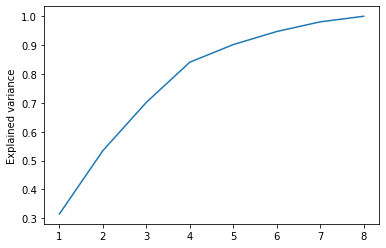

In [55]:
#plotting the explained variance of the principal components
plt.plot(np.arange(1, 9), exp_variance)
plt.ylabel('Explained variance')
plt.show()

As we can see in the plot, the first four principal components actually explain a good ammount of variance, precisely the 84%. So, we can use the first four principal components in our analysis.
Thus, we are going to create a new matrix multiplied by the transposed of the first four eigenvector, then we will perform the ridge regression and the cross validation analysis exactly as we did in the previuous steps. 
Then we are going to modify the level of $ \alpha$ and see how the error change.

In [56]:
#take just the first four eigenvectors 
T = Vh[:4]

In [57]:
#transpose them in order to make the geometry works
T.T

array([[ 0.07577354, -0.70128164,  0.04200347, -0.08398528],
       [-0.07380593,  0.70217864, -0.02205049, -0.0975625 ],
       [-0.22278295,  0.00876762,  0.49700165,  0.83118634],
       [ 0.48465252,  0.07723697, -0.05648816,  0.12098765],
       [ 0.48832181,  0.06044889,  0.13667205,  0.03466523],
       [ 0.47012043,  0.02425325,  0.13350293,  0.07451607],
       [ 0.48953847,  0.06280354,  0.13012449,  0.07493454],
       [ 0.07191266, -0.03033515, -0.8331346 ,  0.51531522]])

In [58]:
#multiplying the original matrix by the eigenvectors transposed. We are expressing the same data but in a differently way 
M = S @ T.T

In [59]:
#applying the ridge regression on the new matrix with a prefixed level of alpha
ridge_reg(M, f, alpha = 0.2)

array([ 0.050472  , -0.03692974, -0.43953867,  0.5657872 ])

In [60]:
#creating the five folds
M.index = f.index 
K = np.random.randint (0, 5, size = f.shape)

In [61]:
#creating the error derived from the new analysis
err_pca = cv_err(M, K, f)

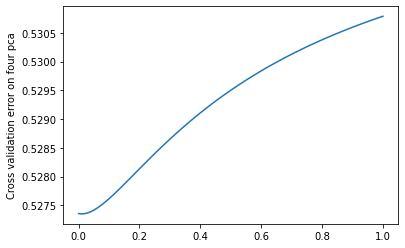

In [62]:
#plotting the errors
plt.plot(np.linspace(0, 1, num = 100), err_pca)
plt.ylabel('Cross validation error on four pca')
plt.show()

The result shows that as much as alpha increase, the error increase too. This is because alpha is said to be a parameter of shrinking as to say, it gives more stability to the predictors at the expense of an higher error. 
Moreover, if we compare this result to the one that we obtained with the original dataset, we can see that the error is bigger also because even if we are catching as much variance as possible, we are still missing some information. 

### Declaration 

I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study.
